<a href="https://colab.research.google.com/github/StoneMason495/cap-comp215/blob/main/COMP215Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prisoners Dilemma:
####By Zach Mason, COMP 215


The Prisoners Dilemma is a segment of game theory, the study of how and why people make certain decisions. The idea of the game is that two criminals are arrested, and placed into separate rooms for questioning. They have no way of communicating with one another, and they must choose between cooperating with authorities, or denying any involvement, with an increase or decrease in sentence depending on the choice of the two participants.

In [15]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

## Prisoner Class:
The main change in the Prisoner class (as is the case with most of this), was just removing any unneccessary inheritance, and making the variable names make more sense, for example the class is now called prisoner instead of agent, and the fitness variable was changed to sentence, all to make better abstraction for a game of Prisoner's Dilemma

In [16]:
class Prisoner:
  '''A single prisoner, used in a game of Prisoners dilemma'''
  #every possible combination of the 'opponents' last two moves, either ('C') cooperate with the other prisoner, or ('D') defect in the hope of a lesser sentence
  lasttwo_sims = [(None, None), #The none here means that less than two games of prisoners dilemma have been played
                  (None, 'C'),
                  (None, 'D'),
                  ('C', 'C'),
                  ('C', 'D'),
                  ('D', 'C'),
                  ('D', 'D')]

  def __init__(self, reactions, sentence=np.nan):
    '''Initialize the prisoner object
    reactions : str or list
    sentence : float'''
    self.reactions = reactions if type(reactions) == list else list(reactions)
    self.combinations = dict(zip(self.lasttwo_sims, reactions))
    self.sentence = sentence

  def reset(self):
    '''Resets the Prisoner back to initialization'''
    self.hist = [None, None]
    self.score = 0

  def mutate(self):
    '''Randomly select one element of the list to switch to the alternative choice (from 'C' to 'D' or vice versa)'''
    index = np.random.choice(len(self.reactions))
    self.reactions[index] = 'C' if self.reactions[index]== 'D' else 'D'
    return self.reactions

  def copy(self, p_mutation=0.05):
    '''Create a clone of the Prisoner, with a chance to change one of the 
       elements to the alternate choice'''
    if random.random() > p_mutation:
      reactions = self.reactions
    else:
      reactions = self.mutate()
    return Prisoner(reactions)
  
  def past_responses(self, past=2):
    '''returns a tuple of the last two responses'''
    return (tuple(self.hist[-past:]))
  
  def respond(self, other):
    '''utilizes the other prisoners last two responses to choose an option,
     from the dictionary created at initialization
     returns str == 'C' or 'D' '''
    hist_key = other.past_responses()
    response = self.combinations[hist_key]
    return response

  def append(self, response, payoff):
    '''Adds the last game to the history list, meaning it will be utilized in the
       next game'''
    self.hist.append(response)
    self.score += payoff

  def random_agents(n_agents):
    '''Creates a list (size = n_agents) of prisoners with random reactions
    n_agents : int'''
    agentlist = [Prisoner(np.random.choice(['C', 'D'], size = 7)) 
                 for i in range(n_agents)
                 ]
    return agentlist

  def identical_prisoners(n_prisoners, val):
    '''Creats a list (size = n_prisoners) of prisoners with the same reaction dict.
    n_prisoners : int
    val: list or str of len(7)'''
    p_list = [Prisoner(val) for i in range (n_prisoners)]
    return p_list


In [17]:
agent = Prisoner.identical_prisoners(10, ('CCDCDCD'))
agent[3].combinations

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

## Metrics:
I kept alot the same for these classes, the only things I really changed were the names. Instruments became Metrics (to better illustrate what they are, metrics to track across a large simulation), the only two I added were the average sentence (MeanSentence), and Cooperation (the mean selection of 'C') 

In [18]:
class Metric:
  '''A parent class of each metric, or measurement we want to measure in a game'''
  def __init__(self):
    self.metrics = []

  def update(self, sim):
    '''How each metric is updated, blank in the parent but defined in the children'''
    pass

  def plot(self, **options):
    plt.plot(self.metrics, **options)

In [19]:
class MeanSentence(Metric):
  '''Calculates the average sentence in each step of a Prisoner's Dilemma simulation'''
  label = 'Mean Sentence'
  
  def update(self, sim):
    '''Appends a new value to the list of mean sentences'''
    mean = np.nanmean(sim.get_sentences())
    self.metrics.append(mean)

In [20]:
class Cooperation(Metric):
  '''Calculates the mean number of times that the prisoners cooperate with police (select 'C')'''
  label = 'Cooperation Freq.'

  def update(self, sim):
    '''Appends a new value to the list of mean Cooperation'''
    responses = np.array([p.reactions[0] for p in sim.prisoners])
    metric = np.mean(responses == 'C')
    self.metrics.append(metric)

## Tournament Class:
The tournament class decides the rules for the tournament, what the 'sentence' is for each combination of 'C' and 'D', how many rounds, etc.

In [21]:
class PD_Tournament:
  '''Class that creates the rules of the simulation'''

  payoffs = {('C', 'C'): (3, 3),
             ('C', 'D'): (0, 5),
             ('D', 'C'): (5, 0),
             ('D', 'D'): (1, 1)}
  num_rounds = 6

  def play(self, pri1, pri2):
    '''play a number of Prisoner's Dilemma rounds (decided by self.num_rounds)
    pri1 : Prisoner
    pri2 : Prisoner
    returns the score of both Prisoners (their sentence)'''
    pri1.reset()
    pri2.reset()

    for i in range(self.num_rounds):
      pri1_resp = pri1.respond(pri2)
      pri2_resp = pri2.respond(pri1)

      pay1, pay2 = self.payoffs[pri1_resp, pri2_resp]

      pri1.append(pri1_resp, pay1)
      pri2.append(pri2_resp, pay2)

    return pri1.score, pri2.score

  def melee(self, prisoners, randomize=True):
    '''Play an agent against two others, the average score is then calculated and
    inputted into .sentence
    prisoners: list (of Prisoners)'''
    if randomize:
      prisoners = np.random.permutation(prisoners)

    n = len(prisoners)
    row_i = np.arange(n)
    row_j = (row_i + 1) % n

    totals = np.zeros(n)

    for i, j in zip(row_i, row_j):
      pris1, pris2 = prisoners[i], prisoners[j]
      score1, score2 = self.play(pris1, pris2)
      totals[i] += score1
      totals[j] += score2
    
    for i in row_i:
      prisoners[i].sentence = totals[i] / self.num_rounds / 2


In [22]:
agents = Prisoner.random_agents(10)
tour = PD_Tournament()
tour.melee(agents)
agents[5].sentence

2.25

## Simulation Class:
In the Simulation class, the biggest changes were removing a seemingly pointless inheritence, and renaming all the 'agents' to 'prisoners' to keep in line with the Prisoner class' renaming.

In [29]:
class PD_Simulation:
  '''A class used to create a simulation of numerous Prisoner's Dilemma games.'''

  def __init__(self, tournament, prisoners):
    '''Create a simulation class.
    tournament : Tournament
    prisoners : list of Prisoners'''
    self.tournament = tournament
    self.prisoners = np.asarray(prisoners)
    self.metrics = []

  def add_metric(self, metric):
    '''Add a metric to the list of metrics
    metric : Class inherting from Metric'''
    self.metrics.append(metric)

  def get_sentences(self):
    '''Get the sentence value of each prisoner'''
    sent = [prisoner.sentence for prisoner in self.prisoners]
    return np.array(sent)

  def step(self):
    '''Advance the simulation one timestep, update metric and replace a random
    percentage of the Prisoners with randoms'''
    self.tournament.melee(self.prisoners)

    n = len(self.prisoners)
    sent = self.get_sentences()
    
    index_gone = self.remove_prisoners(sent)
    num_gone = len(index_gone)

    replacements = self.replace_prisoners(num_gone, sent)
    self.prisoners[index_gone] = replacements

    self.update_metrics()

  def run(self, num_steps=500):
    '''Advance the simulation by more than one timestep, decided by num_steps
    num_steps : int'''
    for i in range(num_steps):
      self.step()

  def update_metrics(self):
    '''Update each metric, by calling its update function'''
    for metric in self.metrics:
        metric.update(self)

  def remove_prisoners(self, ps):
    '''removes some of the prisoners, if the number they draw a number less than
    ps (0.1 by default)
    ps : float < 1.0'''
    n = len(self.prisoners)
    remove = np.random.random(n) < 0.1
    index_out = np.nonzero(remove)[0]
    return index_out

  def replace_prisoners(self, n, weights):
    '''replaces prisoners with copies of a randomly selected prisoner'''
    prisoners = np.random.choice(self.prisoners, size=n, replace=True)
    replacements = [prisoner.copy() for prisoner in prisoners]
    return replacements


## Putting It All Together/Results:
Below, I created a setup to simulate Prisoner's Dilemma for 5000 timesteps, beginning with 100 prisoners who deny no matter what (and the option of creating 100 random prisoners commented out), with two metrics tracked, MeanSentence and Cooperation)

In [35]:
tourney = PD_Tournament()
prisoners = Prisoner.identical_prisoners(100, 'DDDDDDD')
# prisoners = Prisoner.random_agents(100)
sim = PD_Simulation(tourney, prisoners)
sim.add_metric(MeanSentence())
sim.add_metric(Cooperation())
sim.run(5000)

### Graphing:
Here I graphed the two Metrics that I set up, MeanFitness and Cooperation (which appears to transition to an extreme level of either 1 or 0 after a while).

MeanFitness increases, as all the prisoners choose to defect/deny the charges at first (the easiest way to limit a sentence, if all prisoners do it), before increasing to, and heavilly oscillating around a level of around 2.25 years

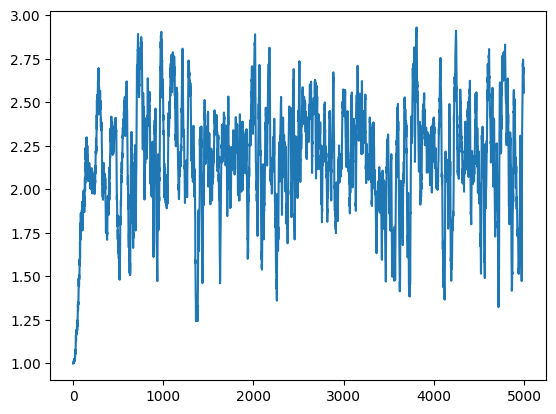

In [36]:
plt.plot(range(5000), sim.metrics[0].metrics)

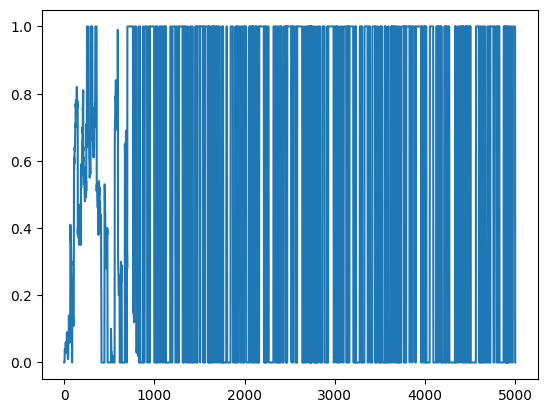

In [37]:
plt.plot(range(5000), sim.metrics[1].metrics)